# Reproducibility of the dataset underpinning the Copernicus Interactive Climate Atlas: Case study

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Production date: DD-MM-YYYY

Dataset version: 2.0.

Produced by: C3S2_521 contract.

## 🌍 Use case: Retrieving climate indicators from the Copernicus Interactive Climate Atlas

## ❓ Quality assessment question
* **Are the climate indicators in the dataset underpinning Copernicus Interactive Climate Atlas consistent with their source datasets?**

The [_Copernicus Interactive Climate Atlas_](https://atlas.climate.copernicus.eu/atlas), or _Atlas_ for short, is a C3S web application providing an easy-to-access tool for exploring climate projections, reanalyses, and observational data [[Guti24](https://doi.org/10.21957/ah52ufc369)].
The application allows the user to interact with 12 datasets:

| Type               | Dataset       |
|--------------------|---------------|
| Climate Projection | CMIP6         |
| Climate Projection | CMIP5         |
| Climate Projection | CORDEX-CORE   |
| Climate Projection | CORDEX-EUR-11 |
| Reanalysis         | ERA5          |
| Reanalysis         | ERA5-Land     |
| Reanalysis         | ORAS5         |
| Reanalysis         | CERRA         |
| Observations       | E-OBS         |
| Observations       | BERKEARTH     |
| Observations       | CPC           |
| Observations       | SST-CCI       |

These datasets are provided through an intermediary dataset, the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) or _Atlas dataset_ for short [[AtlasData](https://doi.org/10.24381/cds.h35hb680)].
Compared to their origins, the versions of the climate datasets within the Atlas dataset have been processed following the workflow in Figure {numref}`{number} <workflow-fig>`.

```{figure} attachment:atlas_dataset_workflow.png
---
height: 360px
name: workflow-fig
---
Schematic representation of the workflow for the production of the Atlas dataset from its origin datasets, from the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/chapter01.html).
```

Because a wide range of users interact with climate data through the Atlas application, it is crucial that the underpinning dataset represent its origins correctly.
In other words, the Atlas dataset must be reproducible from its origins.
In this notebook, we assess this reproducibility by comparing climate indicators retrieved from the Atlas dataset with their equivalents calculated from the origin dataset, mirroring the workflow from Figure {numref}`{number} <workflow-fig>`.
While a full reproduction of the Atlas dataset is outside the scope of quality assessment (and would require high-performance computing infrastructure), a case study with a narrower scope probes the reproducibility of the datasets and can be a jumping-off point for further analysis by the reader.

This assessment is part of a series:
* [](./derived_multi-origin-c3s-atlas_consistency_q01)
* [](./derived_multi-origin-c3s-atlas_consistency_q02)
* [](./derived_multi-origin-c3s-atlas_consistency_q03)
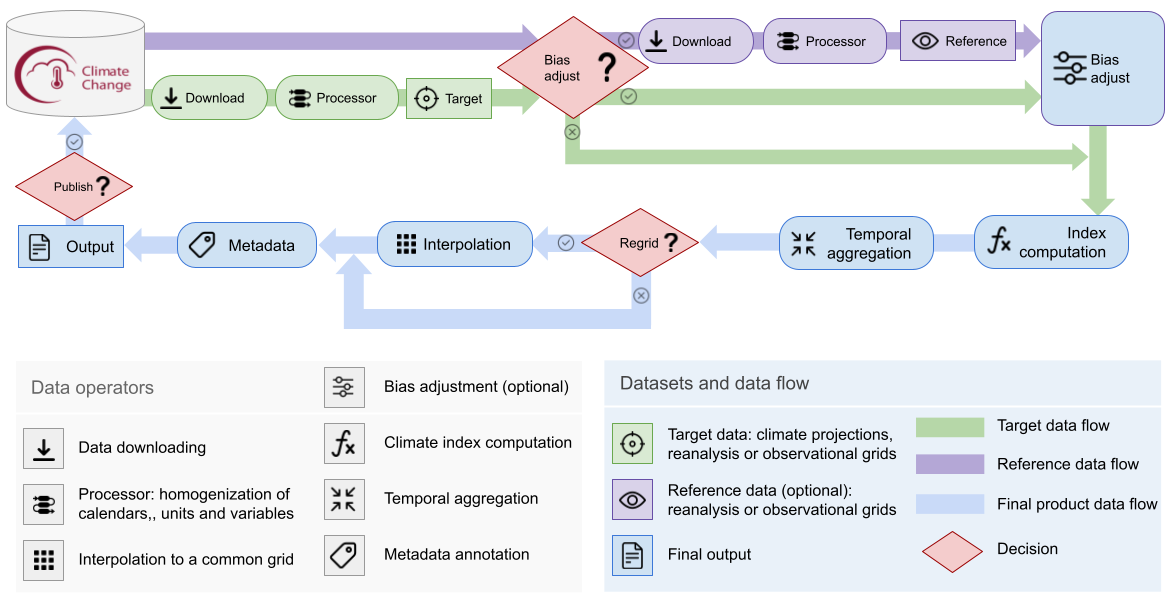

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1: will be a statement on the findings regarding the consistency 
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology
This quality assessment tests the consistency between climate indicators retrieved from the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) [[AtlasData](https://doi.org/10.24381/cds.h35hb680)] and their equivalents calculated from the origin dataset.

This notebook starts the quality assessment with a simple case study: one climate indicator derived from one origin dataset.
We start with the _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ indicator (`tx35`) derived from CMIP6, following [one of the reproducibility notebooks](https://ecmwf-projects.github.io/c3s-atlas/notebooks/tx35.html) written by the data provider.

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Installation of User-tools for the C3S Atlas.
 * Import of all required libraries.
<!---
 * Definition of helper functions.
--->
**[](section-2)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-3)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-4)**
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.
 
**[](section-5)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-6)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-7)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-8)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

**[](section-9)** 
 * Sub-steps or key points listed in bullet below. No strict requirement to match and link to sub-headings.

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the C3S Atlas User Tools
This notebook uses the [C3S Atlas User Tools](https://github.com/ecmwf-projects/c3s-atlas), which can be installed from GitHub using `pip`.
For convenience, we can do this within the notebook itself.
Further details and alternative options for installing this library are available in its [documentation](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

In [1]:
!pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

  Cloning https://github.com/ecmwf-projects/c3s-atlas.git to /tmp/pip-req-build-zzlasu32
  Running command git clone --filter=blob:none --quiet https://github.com/ecmwf-projects/c3s-atlas.git /tmp/pip-req-build-zzlasu32
  Resolved https://github.com/ecmwf-projects/c3s-atlas.git to commit 80256810cb81aa78ab53033479e08cff6a8add44
  Preparing metadata (setup.py) ... done


#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [2]:
# Imports

# For reading files
from pathlib import Path

# For accessing data in the Climate Data Store
import earthkit.data

# For calculating spatiotemporal aggregations
import earthkit.transforms

# For regridding and interpolations
import earthkit.regrid
from earthkit.regrid import interpolate

# For climate data handling
import numpy as np
import xarray as xr
import xclim

# For plotting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# For standarsising the data (NR rewrite this)
from c3s_atlas.fixers import (
    apply_fixers
)

# For regridding 
import c3s_atlas.interpolation as xesmfCICA

from c3s_atlas.utils import (
    plot_month
)

# For calculating metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


(section-2)=
### Case Study - tx35 variable Spain 2060, 2080 

This case study introduces the methodology by focusing on the tx35 variable (monthly count of days with maximum temperature above 35 °C) for Spain under future climate scenarios. The years 2060 and 2080 are chosen to illustrate two contrasting situations: one where differences between datasets are clearly visible (2060) and another where they converge (2080). This provides a clear example of the analysis steps and serves as a template for exploring other variables, regions, and time periods.

References to the next two notebooks (q02, q03)

(section-3)=
### 1.1 Download Climate Data

#### General setup
This notebook uses [<u>earthkit-data<u>](https://github.com/ecmwf/earthkit-data) to download files from the CDS. If you intend to run this notebook multiple times, it is highly recommended that you [<u>enable caching<u>](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.


*(note: section 2 will be functions if they are neccessary)*
The following cell uses [earthkit](https://earthkit-data.readthedocs.io/en/latest/index.html) to download the data from the origin dataset.

In [3]:
#note to NR be unconnected from NPL wifi and VPN to run this cell 
# Use earthkit to download some data (Decided to unpack the dictionary as this is how it is in official docs)

# Define request
CMIP6_ID = "projections-cmip6"
request_CMIP6_tx35 = {
    "temporal_resolution": "daily",
    "experiment": "ssp5_8_5",
    "variable": "daily_maximum_near_surface_air_temperature",
    "model": "cmcc_esm2",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "format": "netcdf"
}


We define a helper function that adds the parameters that are consistent for both .... , to a number of requests.

In [4]:

def make_full_request(request_dataset: dict, *requests: dict) -> dict:
    """ 
    Combine default requests (temporal resolution, experiment, variable, model, format) with a year-specific request (request_year_20xx).
    """
    base_request = request_dataset
    updated_requests = [base_request | req for req in requests]
    return updated_requests


We now define the paramters unique to the data we need. For this example case we will be investigating 2060 and 2080 so we define the requests for these.

In [5]:

request_year_2060 = {"year": ["2060"]}
request_year_2080 = {"year": ["2080"]}


In [6]:

requests_CMIP6_combined = make_full_request(request_CMIP6_tx35, request_year_2060, request_year_2080)

# Download data
ds_CMIP6 = earthkit.data.from_source("cds", CMIP6_ID, *requests_CMIP6_combined)


2025-09-21 12:24:32,582 WARNING [2025-09-19T00:00:00] Scheduled System Session affecting Service reliability - 22 September 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-22-september-2025/14173)
2025-09-21 12:24:32,583 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-21 12:24:32,584 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 140.07it/s]
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/file-4070083748ea7e50fa09710f39df3233301612360ca7ea1267765bb09e7e31ce.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\n\xd3\x00\x00\x03"\x08\x

(section-4)=
### 1.2 Load the data
Earthkit-data downloads the dataset as a field list, which can be manipulated directly. Here, we convert it to an [Xarray](https://docs.xarray.dev/en/stable/) object for ease of use later (when comparing multiple datasets):


In [7]:

print("CMIP6 data type from earthkit-data:", type(ds_CMIP6))
data_CMIP6 = ds_CMIP6.to_xarray(compat="equals")
print("CMIP6 data type in Xarray:", type(data_CMIP6))
data_CMIP6


CMIP6 data type from earthkit-data: <class 'earthkit.data.readers.netcdf.fieldlist.NetCDFMultiFieldList'>
CMIP6 data type in Xarray: <class 'xarray.core.dataset.Dataset'>


/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(


<xarray.Dataset> Size: 167MB
Dimensions:    (time: 730, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 6kB 2060-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 12kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 2MB dask.array<chunksize=(365, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 3MB dask.array<chunksize=(365, 288, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 161MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/a1513d6f-5325-4b99-bbe6-9b096557b100

(section-5)=
### 1.3 Homogenisation 
All the origin datasets need to be homogenised after being downloaded from the CDS, this is done using the [c3s_atlas apply](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas)_fixers function.


- The metadata of the spatial coordinates is homogenised to use standard names, in particular [lon, lat].

- Fix any non-standard calendars used in the data. This typically involves converting the calendars to the CF standard calendar (Mixed Gregorian/Julian) commonly used in climate data.

- Convert the units of the data to a common format (e.g. Celsius for temperature). This prevents us from working with the same variables in different units, for example.

- Convert the longitude values from the [0, 360] format to the [-180, 180] one. This is done to ensure that the longitude variable is common between the different datasets.

- Aggregated to the required temporal resolution. For example, hourly datasets (such as ERA5, ERA5-Land, WFDE5, etc.) will be resampled to daily resolution. This involves using a temporal aggregation method, such as taking the maximum or minimum value for a given variable. As part of this last step, some variable transformations are necessarily applied. For instance, fluxes variables in ERA5 are accumulated, and therefore, the last hour of the day represent daily accumulations. To mention another case, the surface wind is computed as a combination of both the u- and v-components.

In the below cell we specifiy 

In [55]:
# Homogenisation code 
data_CMIP6_2060 = data_CMIP6.where(data_CMIP6["time"].dt.year == 2060, drop=True) # must do this here or the harmonisation aggregates to monthly 
data_CMIP6_2080 = data_CMIP6.where(data_CMIP6["time"].dt.year == 2080, drop=True)

project_id = "cmip6"
variable = 'tasmax'
var_mapping = {
            "dataset_variable": {"tasmax": "data"},
            "aggregation": {"data": "mean"},
        }
data_CMIP6_2060 = apply_fixers(data_CMIP6_2060, variable, project_id, var_mapping)
data_CMIP6_2080 = apply_fixers(data_CMIP6_2080, variable, project_id, var_mapping)
data_CMIP6_2060

2025-09-22 15:06:49,532 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-09-22 15:06:49,554 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 84MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2060-01-01 12:00:00 ... 2060-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 1MB dask.array<chunksize=(365, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 2MB dask.array<chunksize=(365, 288, 2), meta=np.ndarray>
    tasmax     (time, lat, lon) float32 81MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


2025-09-22 15:06:49,660 — UNITS_TRANSFORM — INFO — The dataset tasmax units are not in the correct magnitude. A conversion from K to Celsius will be performed.
2025-09-22 15:06:49,754 — Homogenization-fixers — INFO — The dataset is in daily or monthly resolution, we don't need to resample it from hourly frequency
2025-09-22 15:06:49,756 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-09-22 15:06:49,764 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 84MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB dask.array<chunksize=(1, 2), meta=np.

<xarray.Dataset> Size: 81MB
Dimensions:  (lat: 192, lon: 288, time: 366)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB -178.8 -177.5 -176.2 -175.0 ... 177.5 178.8 180.0
  * time     (time) datetime64[ns] 3kB 2060-01-01 2060-01-02 ... 2060-12-31
    height   float64 8B 2.0
Data variables:
    tasmax   (time, lat, lon) float32 81MB dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                none
    ...                     ...
    title:                  CMCC-ESM2 output prepared for CMIP6
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by CMCC is licensed und...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/a1513d6f-5325-4b99-bbe6-9b096557b100

(section-6)= 
### 1.4 Calculate index (tx35) and aggregate to monthly (MS) temporal resolution using xclim

[xclim](https://xclim.readthedocs.io/en/stable/) is an operational Python library for climate services, providing a framework for constructing custom climate indicators and indices.

In [9]:
# code to calculate tx35 and change temporal resolution 
da_tx35_2060 = xclim.indices.tx_days_above(data_CMIP6_2060['tasmax'], thresh='35.0 degC', 
                                      freq='MS', op='>')
da_tx35_2080 = xclim.indices.tx_days_above(data_CMIP6_2080['tasmax'], thresh='35.0 degC', 
                                      freq='MS', op='>')

# Convert DataArray to Dataset with specified variable name
ds_tx35_2060 = da_tx35_2060.to_dataset(name='tx35')
ds_tx35_2080 = da_tx35_2080.to_dataset(name='tx35')



(section-7)= 
### 1.5 Interpolation to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using conda as explained in its documentation.
Users who cannot or do not wish to use conda will have to manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines, which is not trivial.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

Interpolation to a common and regular grid using 

In [10]:

# interpolate data original order
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(-89.5, 90.5, 1),
            'lons' : np.arange(-179.5, 180.5, 1),
            'var_name' : 'tx35'
}

INTER = xesmfCICA.Interpolator(int_attr)

ds_tx35_2060_i = INTER(ds_tx35_2060)
ds_tx35_2080_i = INTER(ds_tx35_2080)


ds_tx35_2060_i

/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


<xarray.Dataset> Size: 6MB
Dimensions:   (lon: 360, lat: 180, time: 12, bnds: 2)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 96B 2060-01-01 2060-02-01 ... 2060-12-01
Dimensions without coordinates: bnds
Data variables:
    tx35      (time, lat, lon) int64 6MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 6kB -180.0 -179.0 -179.0 ... 179.0 179.0 180.0
    lat_bnds  (lat, bnds) float64 3kB -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    crs       int64 8B 0
    height    float64 8B 2.0

(section-7)= 
### 1.6 Download the data from the Atlas dataset

In this section, the dataset produced above is downloaded from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview) using [earthkit](https://earthkit.readthedocs.io/en/latest/). The results of both of the datasets are compared to determine reproducibility.

In [11]:
# Use earthkit to download the Atlas dataset

# Define request
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "ssp5_8_5",
    "period": "2015-2100",
    "variable": "monthly_extreme_hot_days",
    "bias_adjustment": "no_bias_adjustment"
}

# Download data
ds_C3S_Atlas = earthkit.data.from_source("cds", dataset, request)

2025-09-21 12:24:46,308 WARNING [2025-09-19T00:00:00] Scheduled System Session affecting Service reliability - 22 September 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-22-september-2025/14173)
2025-09-21 12:24:46,309 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-21 12:24:46,310 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
Unknown file type, no reader available. path=/tmp/earthkit-data-nr2/cds-5ba5ca838418756172cfe1e8f80c95a0dd6278bdd897540dd45600415af5ce43.d/provenance.png magic=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x08\xf5\x00\x00\x03\x10\x08\x02\x00\x00\x00\xcaqU\xdb\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xd

In [41]:
# load data with xarray 
ds_tx35_C3S_Atlas = xr.open_dataset(ds_C3S_Atlas)
ds_tx35_C3S_Atlas


/home/nr2/miniforge3/envs/atlasenv/lib/python3.13/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 5GB
Dimensions:          (lat: 180, bnds: 2, lon: 360, time: 1032, member: 20)
Coordinates:
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) datetime64[ns] 8kB 2015-01-01 ... 2100-12-01
    member_id        (member) <U45 4kB ...
    gcm_institution  (member) <U19 2kB ...
    gcm_model        (member) <U16 1kB ...
    gcm_variant      (member) <U8 640B ...
    threshold35c     float64 8B ...
    height2m         float64 8B ...
Dimensions without coordinates: bnds, member
Data variables:
    lat_bnds         (lat, bnds) float64 3kB ...
    lon_bnds         (lon, bnds) float64 6kB ...
    time_bnds        (time, bnds) datetime64[ns] 17kB ...
    tx35             (member, time, lat, lon) float32 5GB ...
    crs              int32 4B ...
Attributes: (12/26)
    Conventions:                CF-1.9 ACDD-1.3
    title:                      Copernicus Interactive Climate Atlas: gridded...
    summary:                    Monthly/annual gridded data from observations...
    institution:                Copernicus Climate Change Service (C3S)
    producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
    license:                    CC-BY 4.0, https://creativecommons.org/licens...
    ...                         ...
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lon_resolution:  1.0
    geospatial_lon_units:       degrees_east
    date_created:               2024-12-05 16:37:49.749769+01:00
    tracking_id:                1a7a60e7-7787-48b5-b18f-a7bf7b4de4be

In [13]:
# define the same dataset
# select a specific member of the ensemble
select_member = [
    str(mem.data) for mem in ds_tx35_C3S_Atlas.member_id if "cmcc-esm2" in str(mem.data).lower()
][0]
print(select_member)

ds_tx35_C3S_Atlas_2060 = ds_tx35_C3S_Atlas.sel(
    member = np.where(ds_tx35_C3S_Atlas.member_id == select_member)[0], 
    time = "2060"
)

ds_tx35_C3S_Atlas_2080 = ds_tx35_C3S_Atlas.sel(
    member = np.where(ds_tx35_C3S_Atlas.member_id == select_member)[0], 
    time = "2080"
)

ds_tx35_C3S_Atlas_2080 = ds_tx35_C3S_Atlas_2080.squeeze('member')
ds_tx35_C3S_Atlas_2080


CMCC_CMCC-ESM2_r1i1p1f1


<xarray.Dataset> Size: 3MB
Dimensions:          (lat: 180, bnds: 2, lon: 360, time: 12)
Coordinates:
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) datetime64[ns] 96B 2080-01-01 ... 2080-12-01
    member_id        <U45 180B 'CMCC_CMCC-ESM2_r1i1p1f1'
    gcm_institution  <U19 76B ...
    gcm_model        <U16 64B ...
    gcm_variant      <U8 32B ...
    threshold35c     float64 8B ...
    height2m         float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds         (lat, bnds) float64 3kB ...
    lon_bnds         (lon, bnds) float64 6kB ...
    time_bnds        (time, bnds) datetime64[ns] 192B ...
    tx35             (time, lat, lon) float32 3MB ...
    crs              int32 4B ...
Attributes: (12/26)
    Conventions:                CF-1.9 ACDD-1.3
    title:                      Copernicus Interactive Climate Atlas: gridded...
    summary:                    Monthly/annual gridded data from observations...
    institution:                Copernicus Climate Change Service (C3S)
    producers:                  Institute of Physics of Cantabria (IFCA, CSIC...
    license:                    CC-BY 4.0, https://creativecommons.org/licens...
    ...                         ...
    geospatial_lon_min:         -180.0
    geospatial_lon_max:         180.0
    geospatial_lon_resolution:  1.0
    geospatial_lon_units:       degrees_east
    date_created:               2024-12-05 16:37:49.749769+01:00
    tracking_id:                1a7a60e7-7787-48b5-b18f-a7bf7b4de4be

(section-8)=
### 1.7 Compare the results 

#### Results Subsections
Describe what is done in this step/section and what the `code` in the cell does (if code is included). 

If this is the **results section**, we expect the final plots to be created here with a description of how to interpret them, and what information can be extracted for the specific use case and user question. The information in the 'quality assessment statement' should be derived here. 

In [14]:
import earthkit.plots as ekp  #make all plots with earthkit 
zoomin_extent = [-9.5, 3.5, 35.5, 44.5]
lat_bounds = (35.5, 44.5)
lon_bounds = (-9.5, 3.5)
proj = ccrs.PlateCarree()

Results comparison for 2080 

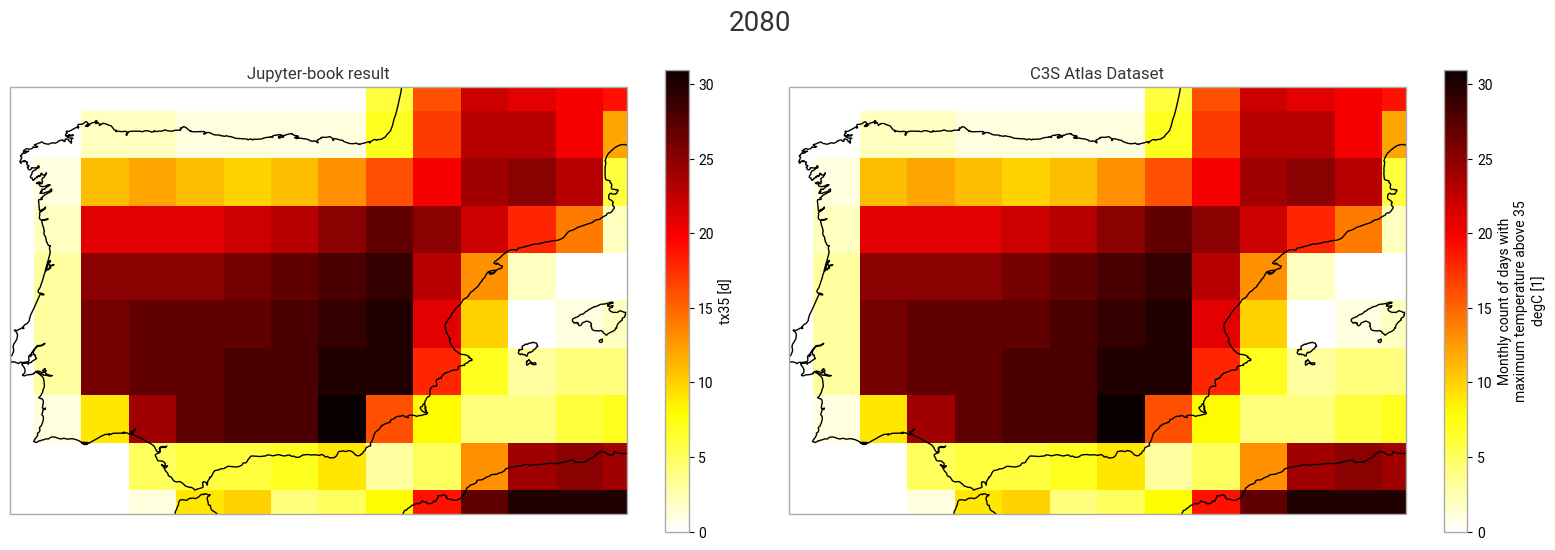

In [15]:

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))

# use the plot_month function from user-tools
plot_month(ax[0], ds_tx35_2080_i, 'tx35', 8, 'Jupyter-book result', 'hot_r')
ax[0].set_extent(zoomin_extent)
plot_month(ax[1], ds_tx35_C3S_Atlas_2080, 'tx35', 8, 'C3S Atlas Dataset', 'hot_r')
ax[1].set_extent(zoomin_extent)
plt.subplots_adjust(wspace=0.01, hspace=0.1) 
fig.suptitle("Plots over Spain for the tx35 variable fo the year 2080", fontsize = 20)


Plotting the difference between the two datasets 

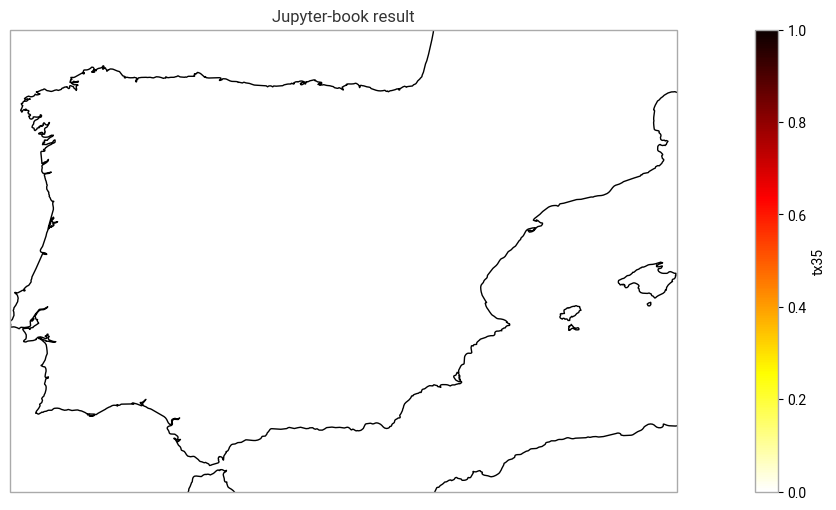

In [16]:

diff_2080 = ds_tx35_2080_i - ds_tx35_C3S_Atlas_2080
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': proj}, figsize=(20, 6))
ax.set_extent(zoomin_extent)
plot_month(ax, diff_2080, 'tx35', 8, 'Difference between the Jupyter-book result and the C3S Atlas Dataset', 'hot_r')


Text(0.5, 0.98, '2060')

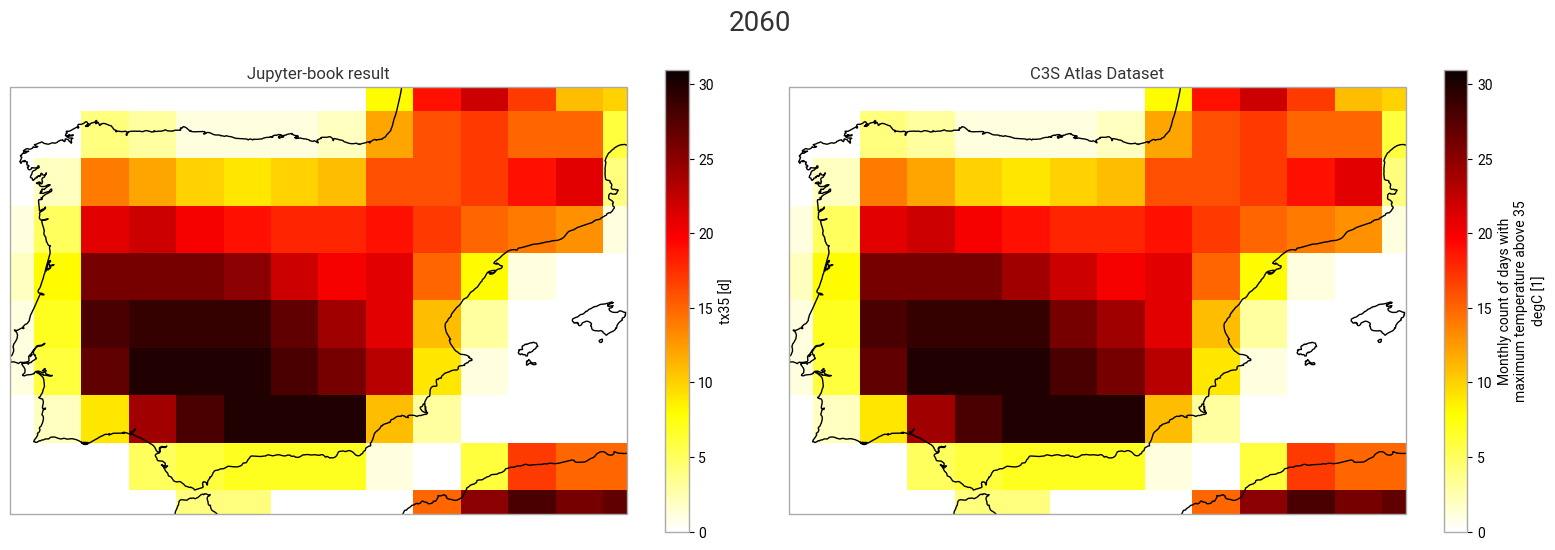

In [17]:

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))

# user-tools
plot_month(ax[0], ds_tx35_2060_i, 'tx35', 8, 'Jupyter-book result', 'hot_r')
ax[0].set_extent(zoomin_extent)

# workflow (intermediate dataset)
plot_month(ax[1], ds_tx35_C3S_Atlas_2060, 'tx35', 8, 'C3S Atlas Dataset', 'hot_r')
ax[1].set_extent(zoomin_extent)
plt.subplots_adjust(wspace=0.01, hspace=0.1) 
fig.suptitle("Plots over Spain for the tx35 variable fo the year 2060", fontsize = 20)


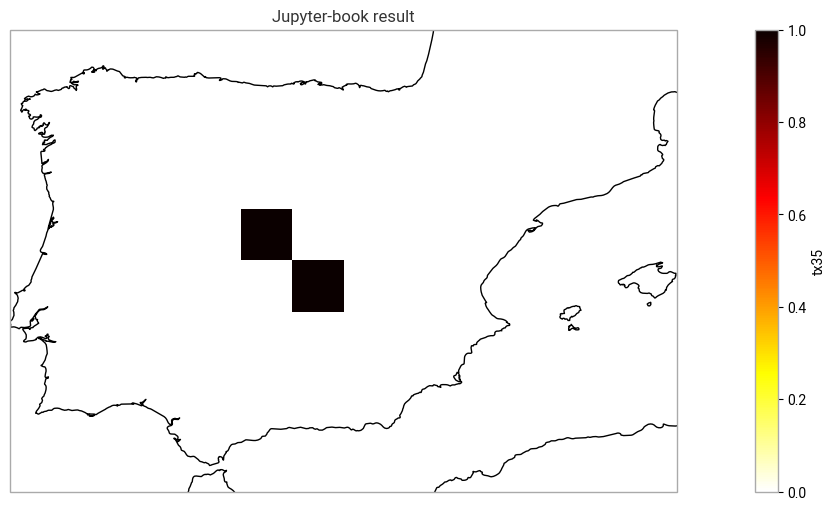

In [18]:

diff_2060 = ds_tx35_2060_i - ds_tx35_C3S_Atlas_2060
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': proj}, figsize=(20, 6))
ax.set_extent(zoomin_extent)
plot_month(ax, diff_2060, 'tx35', 8, "Difference between the Jupyter-book result and the C3S Atlas Dataset", 'hot_r')


In [19]:
# Metrics
atlas = ds_tx35_2060_i['tx35']  #DataArray
jn = ds_tx35_C3S_Atlas_2060['tx35']  #DataArray

lat_bounds = (35.5, 44.5)
lon_bounds = (-9.5, 3.5)

atlas_subset = atlas.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
jn_subset = jn.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

# Align time - maybe use xr.align
common_time = np.intersect1d(atlas_subset['time'], jn_subset['time'])
atlas_subset = atlas_subset.sel(time=common_time)
jn_subset = jn_subset.sel(time=common_time)

atlas_flat = atlas_subset.values.flatten()
jn_flat = jn_subset.values.flatten()

# mask out NaNs
mask = ~np.isnan(atlas_flat) & ~np.isnan(jn_flat)
atlas_clean = atlas_flat[mask]
jn_clean = jn_flat[mask]

# calculate metrics
mae = mean_absolute_error(atlas_clean, jn_clean)
rmse = np.sqrt(mean_squared_error(atlas_clean, jn_clean))
correlation = np.corrcoef(atlas_clean, jn_clean)[0, 1]

print(f"MAE Original: {mae:.4f}")
print(f"RMSE Original: {rmse:.4f}")
print(f"Correlation Original: {correlation:.4f}")

#median absolute difference 
# add global plot and metrics

MAE Original: 0.0012
RMSE Original: 0.0345
Correlation Original: 1.0000


## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References
_To be replaced with numerical references once the text is finished_

[[Guti24](https://doi.org/10.21957/ah52ufc369)] J. M. Gutiérrez et al., ‘The Copernicus Interactive Climate Atlas: a tool to explore regional climate change’, ECMWF Newsletter, vol. 181, pp. 38–45, Oct. 2024, doi: 10.21957/ah52ufc369.

[[AtlasData](https://doi.org/10.24381/cds.h35hb680)] Copernicus Climate Change Service, ‘Gridded dataset underpinning the Copernicus Interactive Climate Atlas’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Jun. 17, 2024. doi: 10.24381/cds.h35hb680.